# Pre-Processing

# SMOTE FOR IMBALANCED CLASSES

In [ ]:
import os
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from imblearn.keras import balanced_batch_generator

# Define the dataset path
WORKINGDIRECTORY = "/kaggle/input/mri-alzheimer-dataset/Dataset"

# Class labels
CLASSES = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Verify if the directory exists
if not os.path.exists(WORKINGDIRECTORY):
    raise FileNotFoundError(f"Directory '{WORKINGDIRECTORY}' not found.")

# Rescale images using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load images with resizing
train_dataset = datagen.flow_from_directory(WORKINGDIRECTORY, target_size=(150, 150), batch_size=6400, shuffle=True)

# Load the full dataset into memory
X, y = [], []
for batch in train_dataset:
    X_batch, y_batch = batch
    X.append(X_batch)
    y.append(y_batch)
    # Break loop when all batches are processed
    if len(X) * 6400 >= len(train_dataset):
        break

# Concatenate the batches to form the full dataset
X = np.concatenate(X)
y = np.concatenate(y)

# Convert class labels (y) to categorical format if necessary
# y = to_categorical(y) if not in one-hot format

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Check class distribution before applying SMOTE
print("Class distribution before SMOTE:")
print("Train: ", sorted(Counter(np.argmax(y_train, axis=1)).items()))

# Flatten the data for SMOTE since SMOTE requires 2D input (you can reshape it back later for training)
X_train_flat = X_train.reshape((X_train.shape[0], -1))
y_train_flat = np.argmax(y_train, axis=1)

# Apply SMOTE to balance the class distribution in the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_flat, y_train_flat)

# Reshape the resampled data back to the original dimensions
X_train = X_train.reshape((X_train.shape[0], 150, 150, 3))

# Convert resampled y back to one-hot encoding
y_train = np.eye(len(CLASSES))[y_train]

# Check class distribution after applying SMOTE
print("Class distribution after SMOTE:")
print("Train: ", sorted(Counter(np.argmax(y_train, axis=1)).items()))

# Number of samples after train, validation, and test split
print("Train Shape: ", X_train.shape, y_train.shape)
print("Validation Shape: ", X_val.shape, y_val.shape)
print("Test Shape: ", X_test.shape, y_test.shape)


## RESNET

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

def create_resnet(input_shape, l2_lambda=0.01):
    inputs = Input(input_shape)
    
    # First convolutional block with L2 regularization
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second convolutional block with L2 regularization
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Flatten layer
    flat = Flatten()(pool2)
    
    # Dense layer with L2 regularization
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(flat)
    
    # Output layer
    outputs = Dense(4, activation='softmax')(dense1)  # 4 classes in the output layer

    # Create the model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create ResNet model with L2 regularization
model_resnet = create_resnet(input_shape=(150, 150, 3), l2_lambda=0.01)

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=0.0001)  # Set a custom learning rate
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(X_test, y_test)
print(f"ResNet Test Accuracy: {test_accuracy_resnet}, Test Loss: {test_loss_resnet}")

# Get predictions for validation data
y_val_pred = model_resnet.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Classification report on validation data
print("Classification Report on Validation Data:")
print(classification_report(y_val_true, y_val_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))


Epoch 1/50


I0000 00:00:1727869004.872080     115 service.cc:145] XLA service 0x7ed86000d930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727869004.872163     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 13/281 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2927 - loss: 14.7664

I0000 00:00:1727869008.952974     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.6232 - loss: 5.3277 - val_accuracy: 0.1523 - val_loss: 4.2399
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9587 - loss: 2.0901 - val_accuracy: 0.8053 - val_loss: 2.1117
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9899 - loss: 1.5480 - val_accuracy: 0.9570 - val_loss: 1.3972
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9989 - loss: 1.2073 - val_accuracy: 0.9707 - val_loss: 1.1186
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 1.0000 - loss: 0.9694 - val_accuracy: 0.9740 - val_loss: 0.9208
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 1.0000 - loss: 0.7910 - val_accuracy: 0.9753 - val_loss: 0.7700
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 1.0000 - loss: 0.6515 - val_accuracy: 0.9759 - val_loss: 0.6436
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 1.0000 - loss: 0.5401 - val_accuracy: 0.98

# LeNet

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the model architecture (LeNet) with L2 regularization and Dropout
model_lenet = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(120, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Adding dropout to prevent overfitting
    Dense(84, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Adding dropout to prevent overfitting
    Dense(4, activation='softmax')  # 4 classes in the output layer
])

# Compile the model with Adam optimizer and a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Setting a custom learning rate
model_lenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with reshaped labels for 50 epochs
history_lenet = model_lenet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss_lenet, test_accuracy_lenet = model_lenet.evaluate(X_test, y_test)
print(f"LeNet Test Accuracy: {test_accuracy_lenet}, Test Loss: {test_loss_lenet}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.3262 - loss: 3.7871 - val_accuracy: 0.3841 - val_loss: 2.3324
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5051 - loss: 2.0754 - val_accuracy: 0.6152 - val_loss: 1.7681
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5805 - loss: 1.5813 - val_accuracy: 0.6341 - val_loss: 1.4779
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6246 - loss: 1.3163 - val_accuracy: 0.6654 - val_loss: 1.2860
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6625 - loss: 1.1321 - val_accuracy: 0.6803 - val_loss: 1.1054
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7218 - loss: 0.9920 - val_accuracy: 0.7174 - val_loss: 1.0128
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7485 - loss: 0.8834 - val_accuracy: 0.7383 - val_loss: 0.9267
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7861 - loss: 0.7839 - val_accuracy:

# UNet

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the U-Net model architecture with L2 regularization
def create_unet(input_shape, l2_lambda=0.01):
    inputs = Input(input_shape)
    
    # First convolutional block with L2 regularization
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second convolutional block with L2 regularization
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Flatten layer
    flat = Flatten()(pool2)
    
    # Fully connected layer with L2 regularization
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(flat)
    
    # Output layer
    outputs = Dense(4, activation='softmax')(dense1)  # 4 classes in the output layer

    # Create the model
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Create U-Net model with L2 regularization
model_unet = create_unet(input_shape=(150, 150, 3), l2_lambda=0.01)

# Compile the model with Adam optimizer and a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Set a custom learning rate
model_unet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_unet = model_unet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss_unet, test_accuracy_unet = model_unet.evaluate(X_test, y_test)
print(f"U-Net Test Accuracy: {test_accuracy_unet}, Test Loss: {test_loss_unet}")


Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4554 - loss: 2.4996 - val_accuracy: 0.5833 - val_loss: 1.3601
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7308 - loss: 1.1052 - val_accuracy: 0.7155 - val_loss: 1.0823
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8204 - loss: 0.8457 - val_accuracy: 0.7643 - val_loss: 0.9455
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8700 - loss: 0.7095 - val_accuracy: 0.6589 - val_loss: 1.0545
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8786 - loss: 0.6461 - val_accuracy: 0.7910 - val_loss: 0.8276
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9211 - loss: 0.5585 - val_accuracy: 0.8529 - val_loss: 0.6902
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9395 - loss: 0.4991 - val_accuracy: 0.8333 - val_loss: 0.6897
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9474 - loss: 0.4588 - val_acc

# MobileNet

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the MobileNet model architecture with L2 regularization
def create_mobilenet(input_shape, l2_lambda=0.01):
    # Load MobileNet without pretrained weights and include L2 regularization
    base_model = MobileNet(input_shape=input_shape, weights=None, include_top=False)
    
    # Add a global average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)
    
    # Fully connected layer with L2 regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    
    # Output layer with 4 classes and L2 regularization
    outputs = Dense(4, activation='softmax', kernel_regularizer=l2(l2_lambda))(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

# Create MobileNet model with L2 regularization
model_mobilenet = create_mobilenet(input_shape=(150, 150, 3), l2_lambda=0.01)

# Compile the model with Adam optimizer and a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Set a custom learning rate
model_mobilenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_mobilenet = model_mobilenet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss_mobilenet, test_accuracy_mobilenet = model_mobilenet.evaluate(X_test, y_test)
print(f"MobileNet Test Accuracy: {test_accuracy_mobilenet}, Test Loss: {test_loss_mobilenet}")


Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.3659 - loss: 3.4077 - val_accuracy: 0.3548 - val_loss: 2.9896
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6116 - loss: 2.2441 - val_accuracy: 0.1296 - val_loss: 2.8431
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7057 - loss: 1.6870 - val_accuracy: 0.3893 - val_loss: 1.9991
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7749 - loss: 1.3006 - val_accuracy: 0.5293 - val_loss: 1.7221
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8319 - loss: 1.0138 - val_accuracy: 0.5013 - val_loss: 1.6872
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8811 - loss: 0.7832 - val_accuracy: 0.5794 - val_loss: 1.6238
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9134 - loss: 0.6032 - val_accuracy: 0.5566 - val_loss: 1.5392
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9494 - loss: 0.4478 - 

# DENSENET

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the DenseNet model architecture with L2 regularization and Dropout
def create_densenet(input_shape, l2_lambda=0.01):
    # Load DenseNet121 without pretrained weights and include L2 regularization
    base_model = DenseNet121(input_shape=input_shape, weights=None, include_top=False)
    
    # Add a global average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)
    
    # Fully connected layer with L2 regularization and dropout
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    
    # Output layer with 4 classes and L2 regularization
    outputs = Dense(4, activation='softmax', kernel_regularizer=l2(l2_lambda))(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

# Create DenseNet model with L2 regularization and Dropout
model_densenet = create_densenet(input_shape=(150, 150, 3), l2_lambda=0.01)

# Compile the model with Adam optimizer and a reduced learning rate
optimizer = Adam(learning_rate=0.00001)  # Set a custom learning rate
model_densenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history_densenet = model_densenet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss_densenet, test_accuracy_densenet = model_densenet.evaluate(X_test, y_test)
print(f"DenseNet Test Accuracy: {test_accuracy_densenet}, Test Loss: {test_loss_densenet}")


Epoch 1/50


I0000 00:00:1727870306.344363     114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_3', 8 bytes spill stores, 8 bytes spill loads



281/281 ━━━━━━━━━━━━━━━━━━━━ 245s 402ms/step - accuracy: 0.3829 - loss: 3.6361 - val_accuracy: 0.1361 - val_loss: 3.7843
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.6433 - loss: 3.1498 - val_accuracy: 0.4922 - val_loss: 3.1544
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - accuracy: 0.6978 - loss: 2.8748 - val_accuracy: 0.5221 - val_loss: 3.0881
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.7666 - loss: 2.6654 - val_accuracy: 0.5872 - val_loss: 2.8784
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.8323 - loss: 2.4583 - val_accuracy: 0.6673 - val_loss: 2.6774
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.8915 - loss: 2.2532 - val_accuracy: 0.7201 - val_loss: 2.5256
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.9405 - loss: 2.0755 - val_accuracy: 0.7637 - val_loss: 2.3400
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.9747 - loss: 1.9019 - va

# EfficientNet

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Create EfficientNetB0 model with L2 regularization on the output layer
def create_efficientnet(input_shape, l2_lambda=0.01):
    # Load EfficientNetB0 without pretrained weights and include L2 regularization
    base_model = EfficientNetB0(input_shape=input_shape, weights=None, include_top=False)
    
    # Add a global average pooling layer and a dense layer with L2 regularization
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    outputs = Dense(4, activation='softmax', kernel_regularizer=l2(l2_lambda))(x)  # 4 classes in the output layer
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Create the EfficientNetB0 model with L2 regularization
model_efficientnet = create_efficientnet(input_shape=(150, 150, 3), l2_lambda=0.01)

# Compile the model with Adam optimizer and a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Set a custom learning rate
model_efficientnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history_efficientnet = model_efficientnet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss_efficientnet, test_accuracy_efficientnet = model_efficientnet.evaluate(X_test, y_test)
print(f"EfficientNet Test Accuracy: {test_accuracy_efficientnet}, Test Loss: {test_loss_efficientnet}")


Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 146s 247ms/step - accuracy: 0.4327 - loss: 3.3282 - val_accuracy: 0.3548 - val_loss: 2.7062
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.6965 - loss: 2.0250 - val_accuracy: 0.3548 - val_loss: 2.0621
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.8187 - loss: 1.3139 - val_accuracy: 0.5391 - val_loss: 1.6012
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.8790 - loss: 0.8887 - val_accuracy: 0.6419 - val_loss: 1.3441
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9119 - loss: 0.6207 - val_accuracy: 0.7318 - val_loss: 0.9837
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9301 - loss: 0.4479 - val_accuracy: 0.7435 - val_loss: 0.8404
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9396 - loss: 0.3553 - val_accuracy: 0.7760 - val_loss: 0.7568
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.9445 - loss: 0.2812 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.9933 - loss: 0.0429 - val_accuracy: 0.9043 - val_loss: 0.3476
Epoch 49/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9952 - loss: 0.0426 - val_accuracy: 0.9049 - val_loss: 0.3549
Epoch 50/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9910 - loss: 0.0523 - val_accuracy: 0.9108 - val_loss: 0.3162
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9061 - loss: 0.3949
EfficientNet Test Accuracy: 0.90625, Test Loss: 0.3838862478733063


# Results ploting

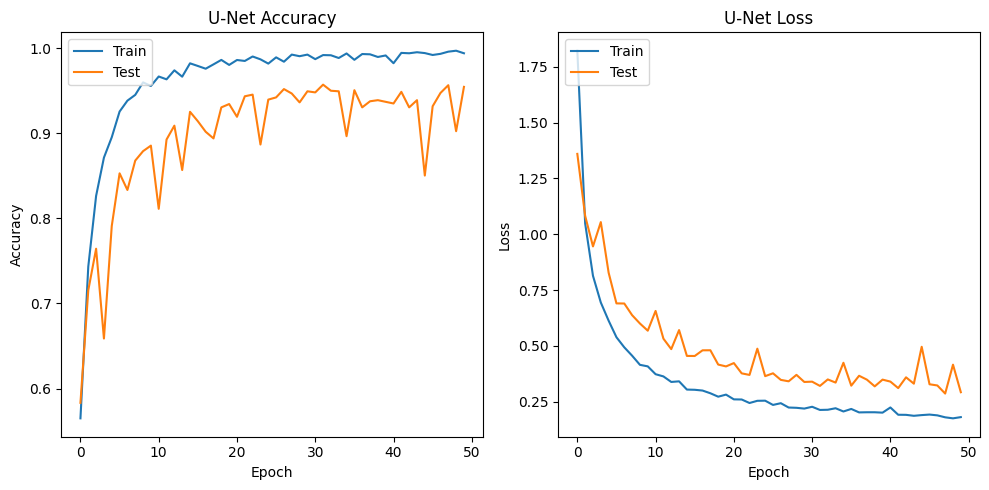

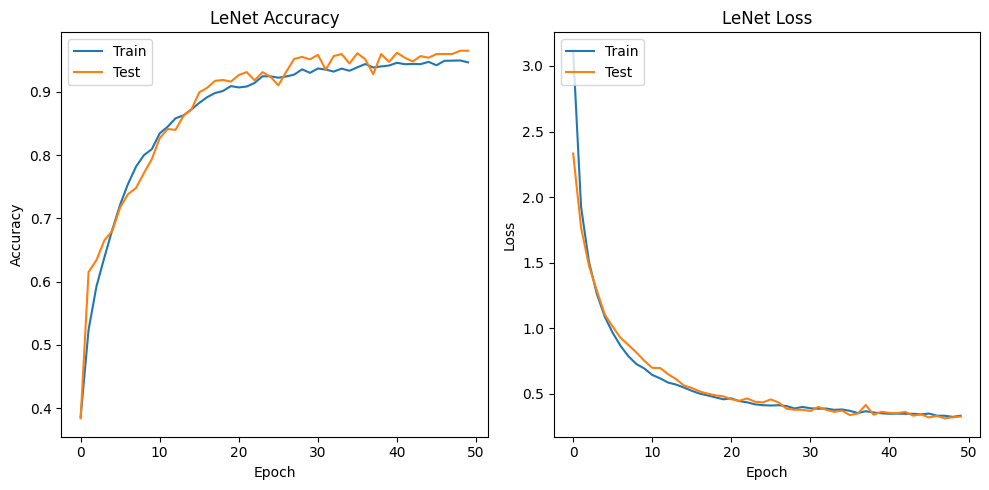

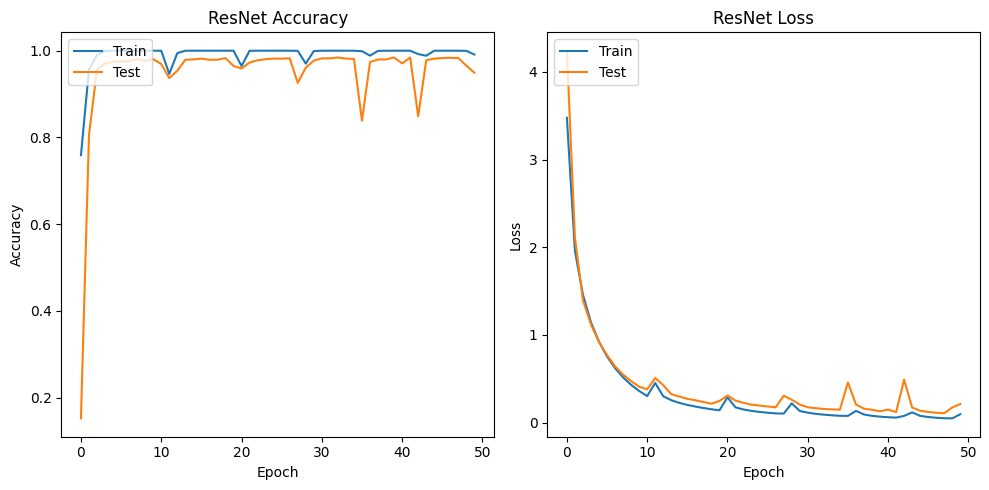

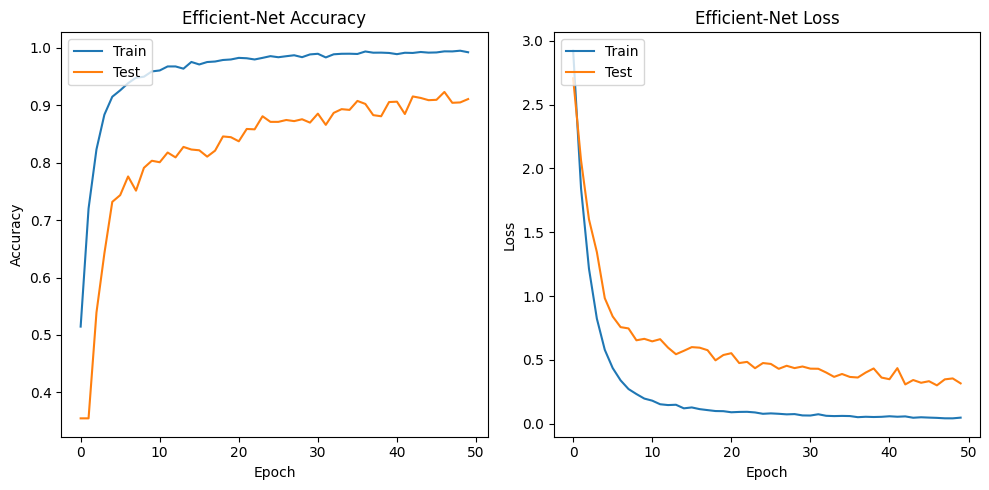

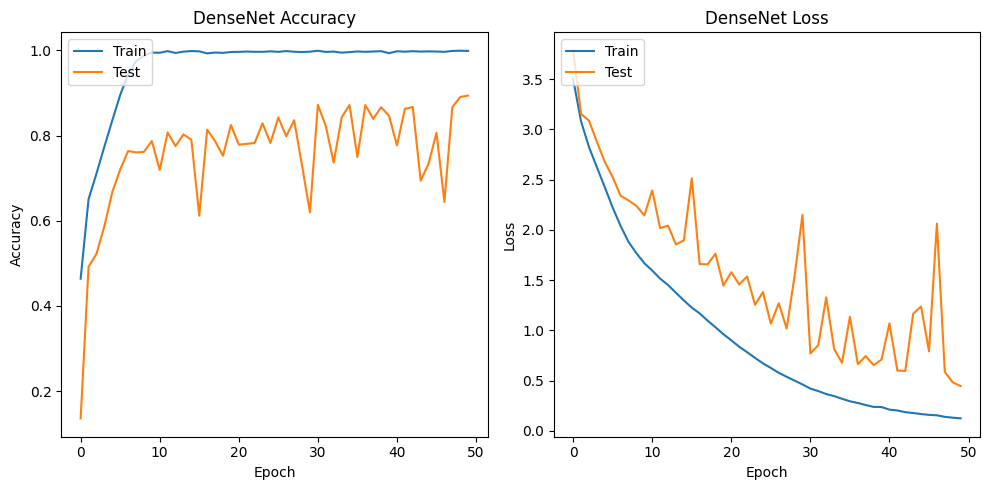

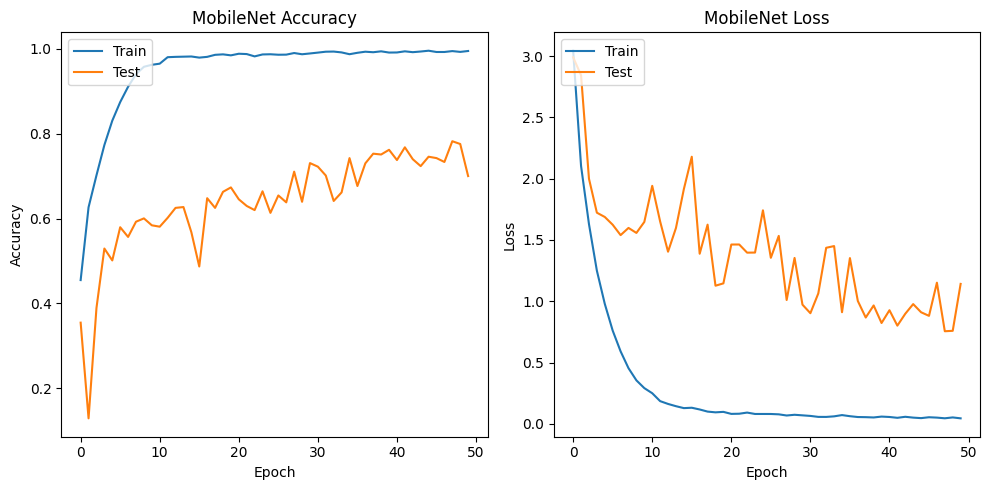

In [31]:
import matplotlib.pyplot as plt

# Define models and their histories (Assuming history_unet and history_lenet exist)
models = [history_unet, history_lenet, history_resnet, history_efficientnet, history_densenet, history_mobilenet]  # Add more histories as needed

# Define model names for titles
model_names = ['U-Net', 'LeNet', 'ResNet', 'Efficient-Net' , 'DenseNet' , 'MobileNet']  # Add model names accordingly

# Plotting loop
for i, history in enumerate(models):
    plt.figure(figsize=(10, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_names[i]} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_names[i]} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'{model_names[i]}_plot.png')
    plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


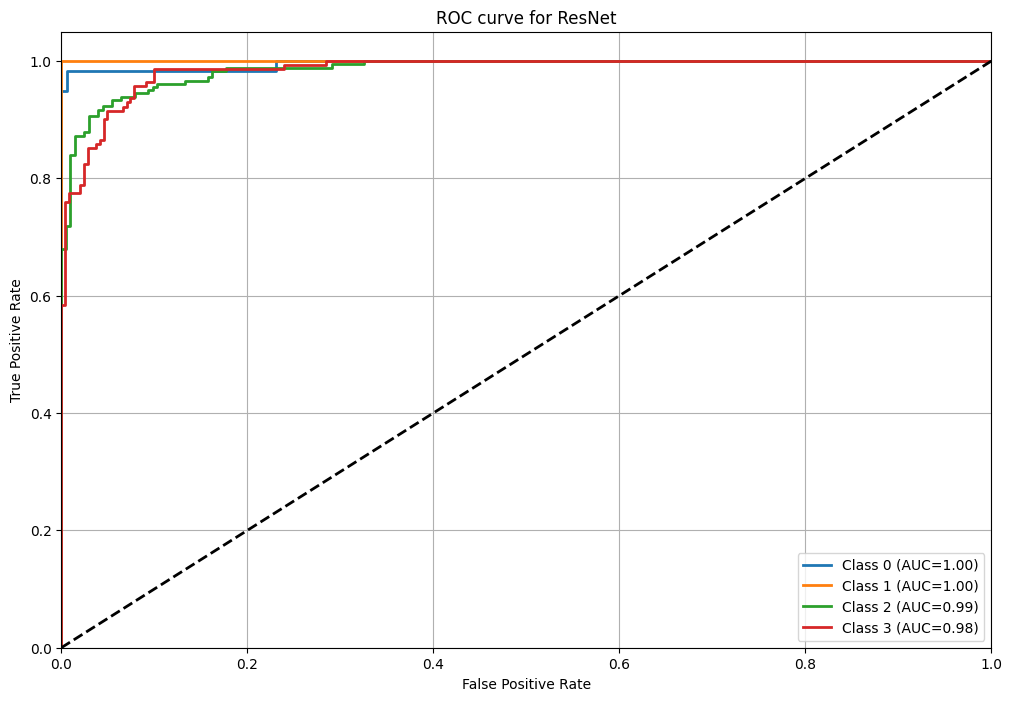

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


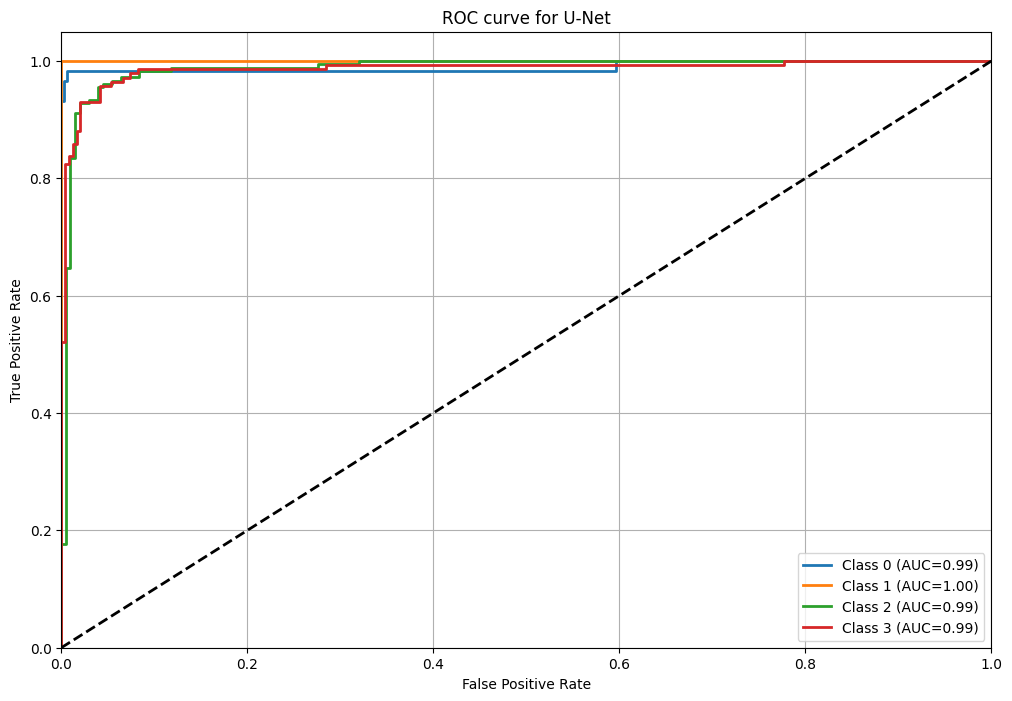

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


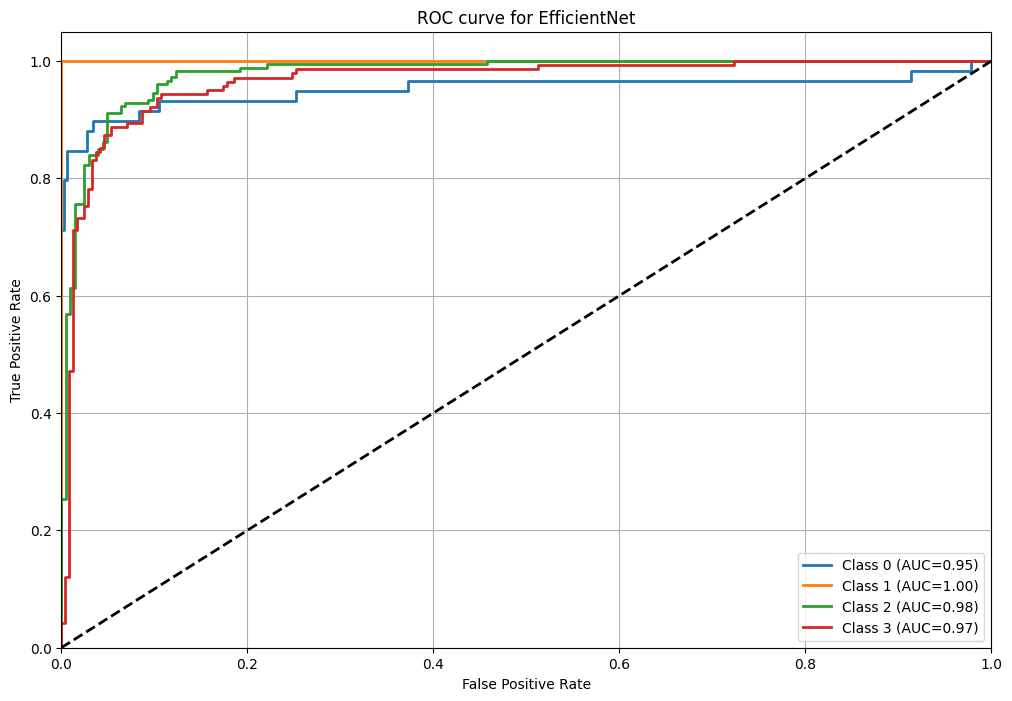

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


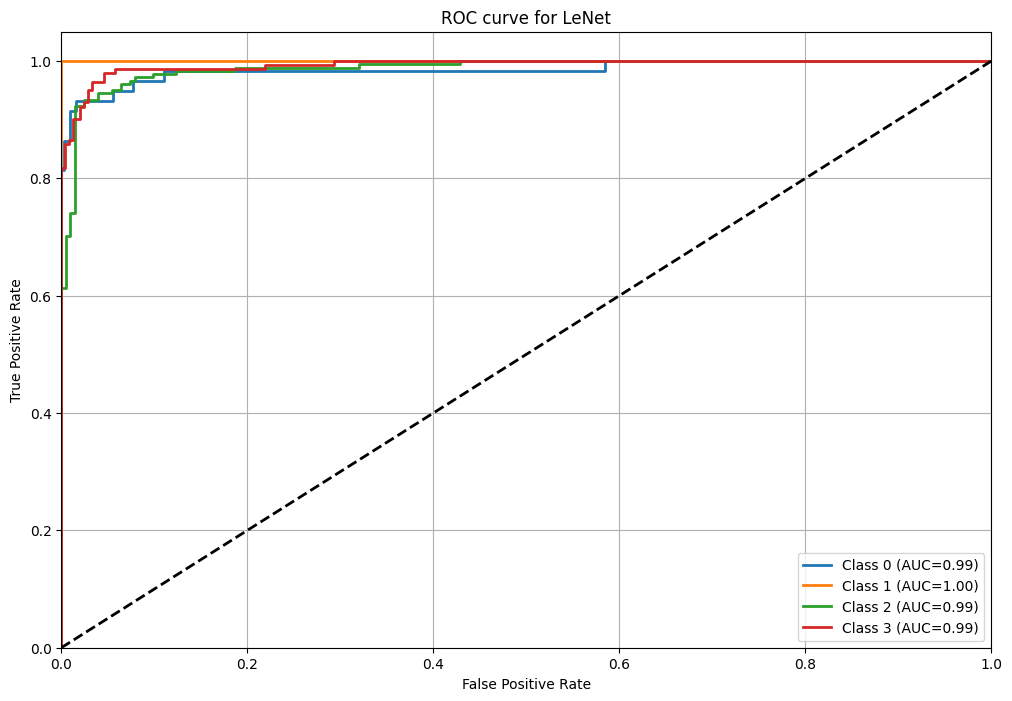

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


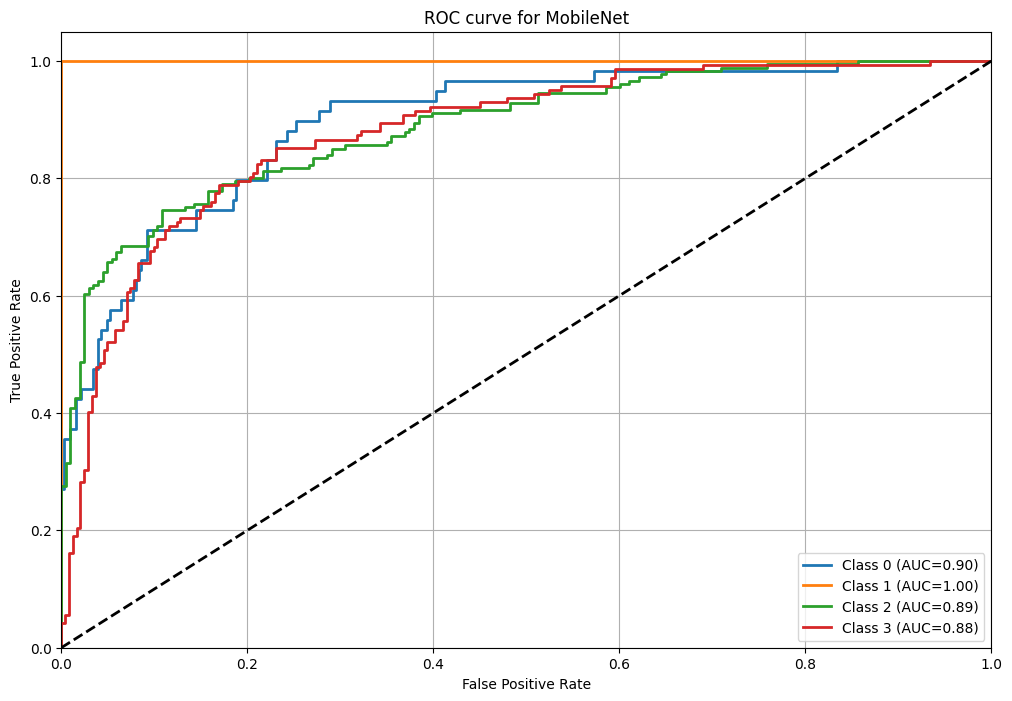

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step


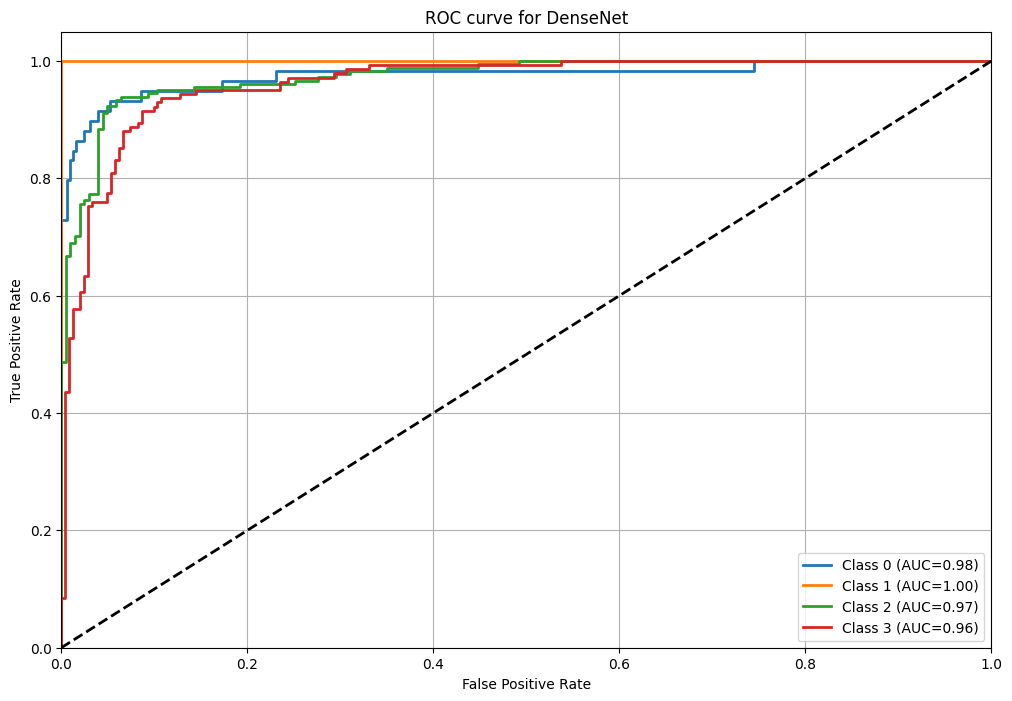

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Helper function to plot ROC curve for each class
def plot_roc_curve(y_true, y_pred_probs, model_name, class_names):
    plt.figure(figsize=(12, 8))
    
    for i, class_name in enumerate(class_names):
        # Calculate ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# True labels for the test set (one-hot encoded)
y_true = y_test

# Class names for your 4 classes
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# -------------------- ResNet --------------------
# Predict probabilities for the test set using ResNet
y_pred_probs_resnet = model_resnet.predict(X_test)

# Plot ROC curve for ResNet
plot_roc_curve(y_true, y_pred_probs_resnet, model_name="ResNet", class_names=class_names)

# -------------------- U-Net --------------------
# Predict probabilities for the test set using U-Net
y_pred_probs_unet = model_unet.predict(X_test)

# Plot ROC curve for U-Net
plot_roc_curve(y_true, y_pred_probs_unet, model_name="U-Net", class_names=class_names)

# -------------------- EfficientNet --------------------
# Predict probabilities for the test set using EfficientNet
y_pred_probs_efficientnet = model_efficientnet.predict(X_test)

# Plot ROC curve for EfficientNet
plot_roc_curve(y_true, y_pred_probs_efficientnet, model_name="EfficientNet", class_names=class_names)

# -------------------- LeNet --------------------
# Predict probabilities for the test set using LeNet
y_pred_probs_lenet = model_lenet.predict(X_test)

# Plot ROC curve for LeNet
plot_roc_curve(y_true, y_pred_probs_lenet, model_name="LeNet", class_names=class_names)

# -------------------- MobileNet --------------------
# Predict probabilities for the test set using MobileNet
y_pred_probs_mobilenet = model_mobilenet.predict(X_test)

# Plot ROC curve for MobileNet
plot_roc_curve(y_true, y_pred_probs_mobilenet, model_name="MobileNet", class_names=class_names)

# -------------------- DenseNet --------------------
# Predict probabilities for the test set using DenseNet
y_pred_probs_densenet = model_densenet.predict(X_test)

# Plot ROC curve for DenseNet
plot_roc_curve(y_true, y_pred_probs_densenet, model_name="DenseNet", class_names=class_names)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


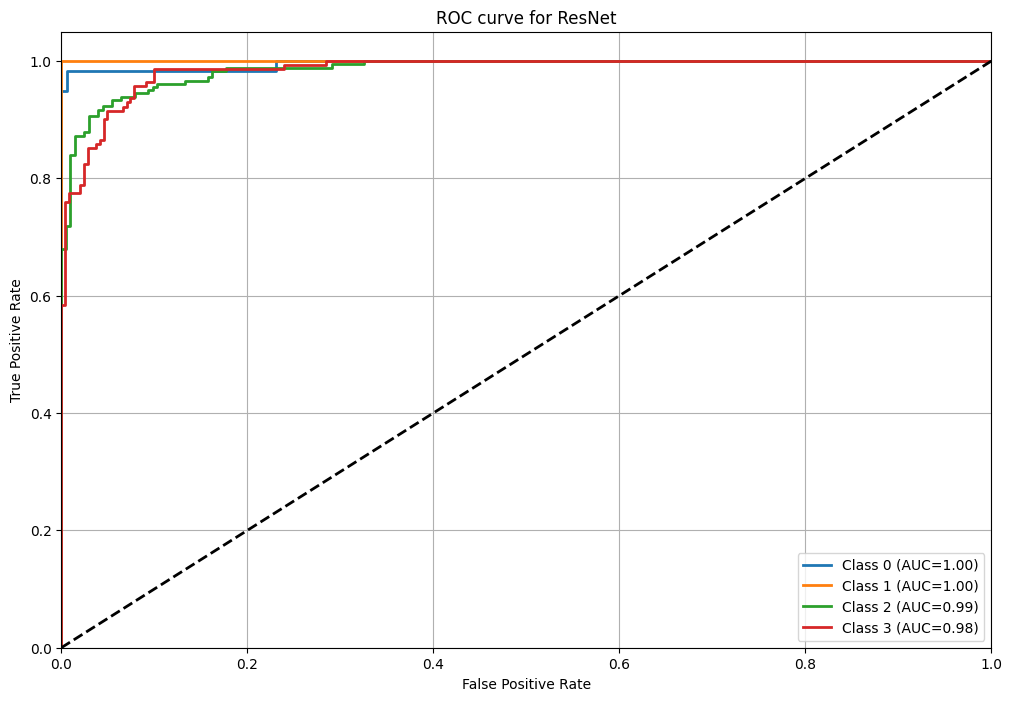

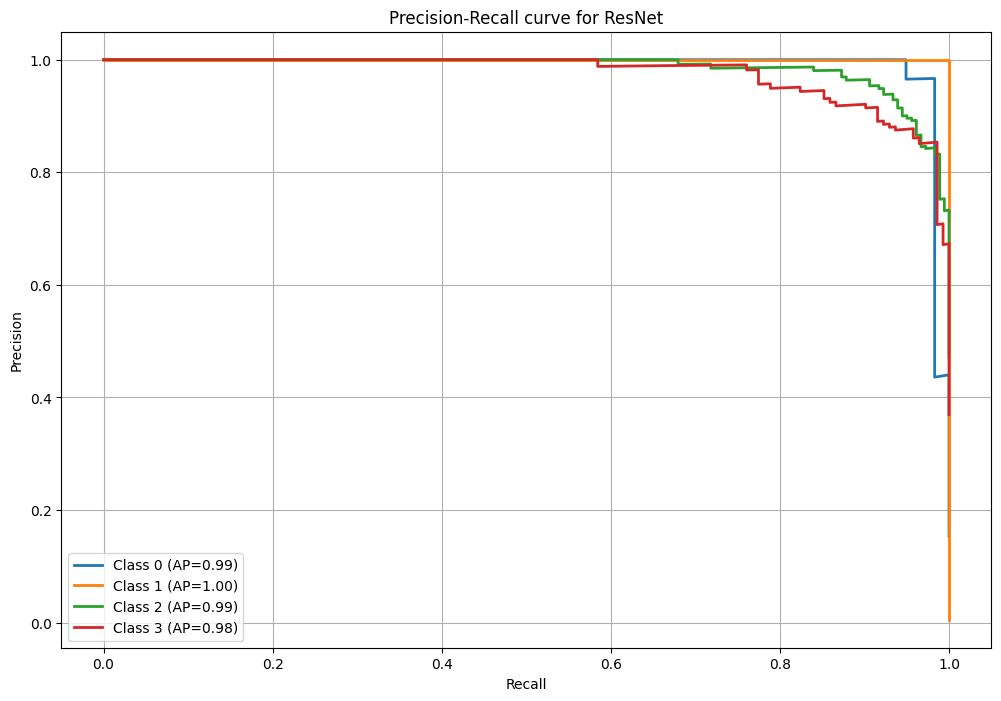

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


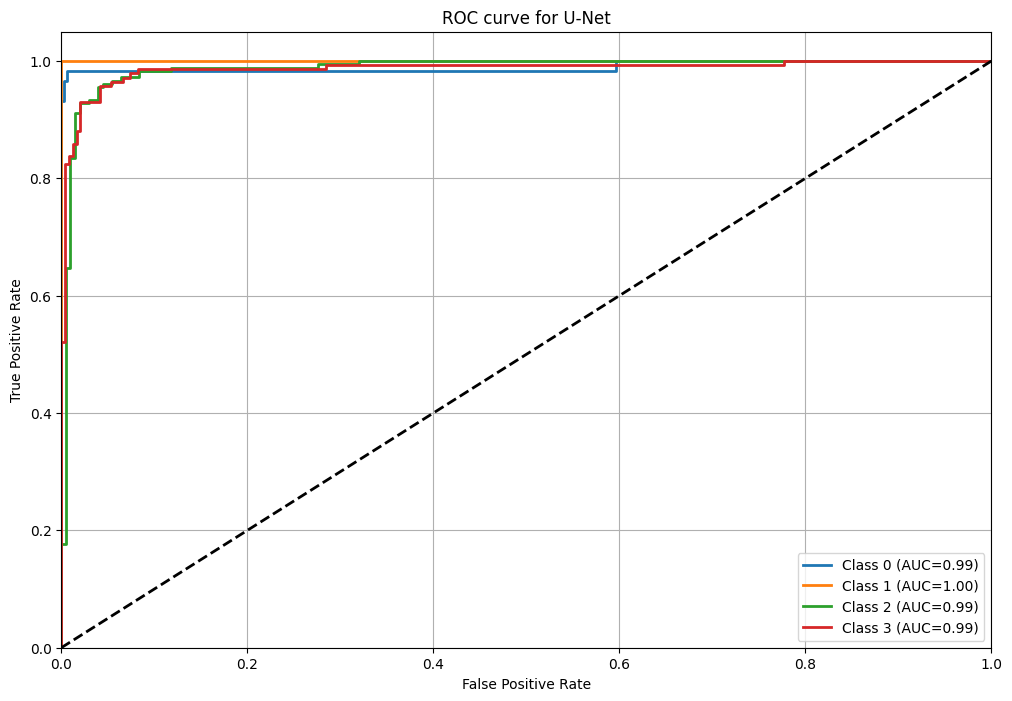

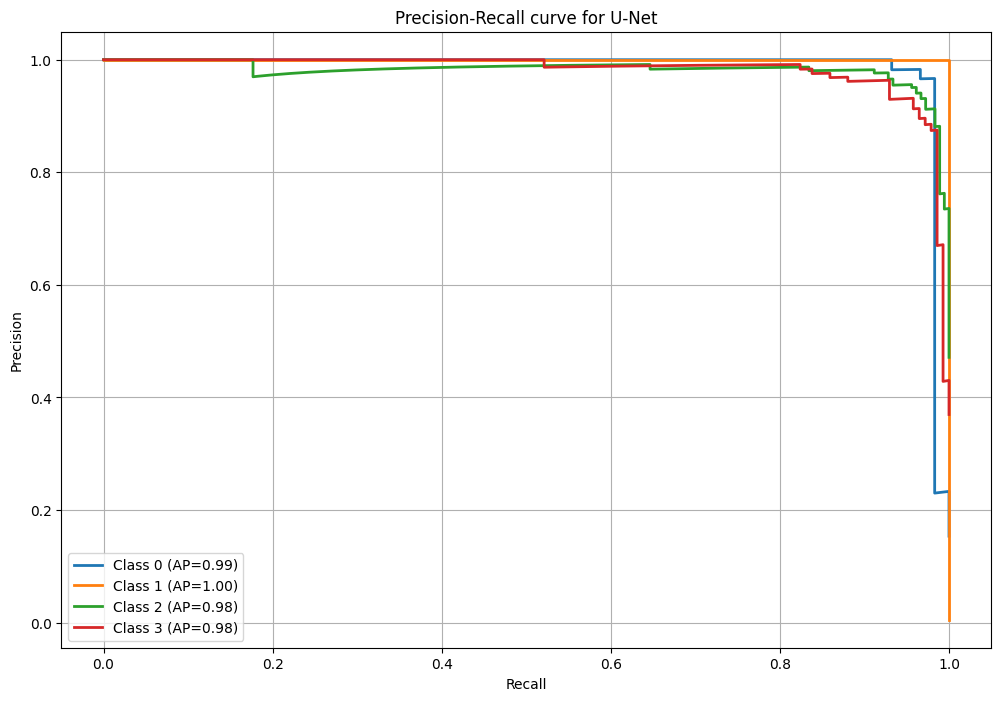

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


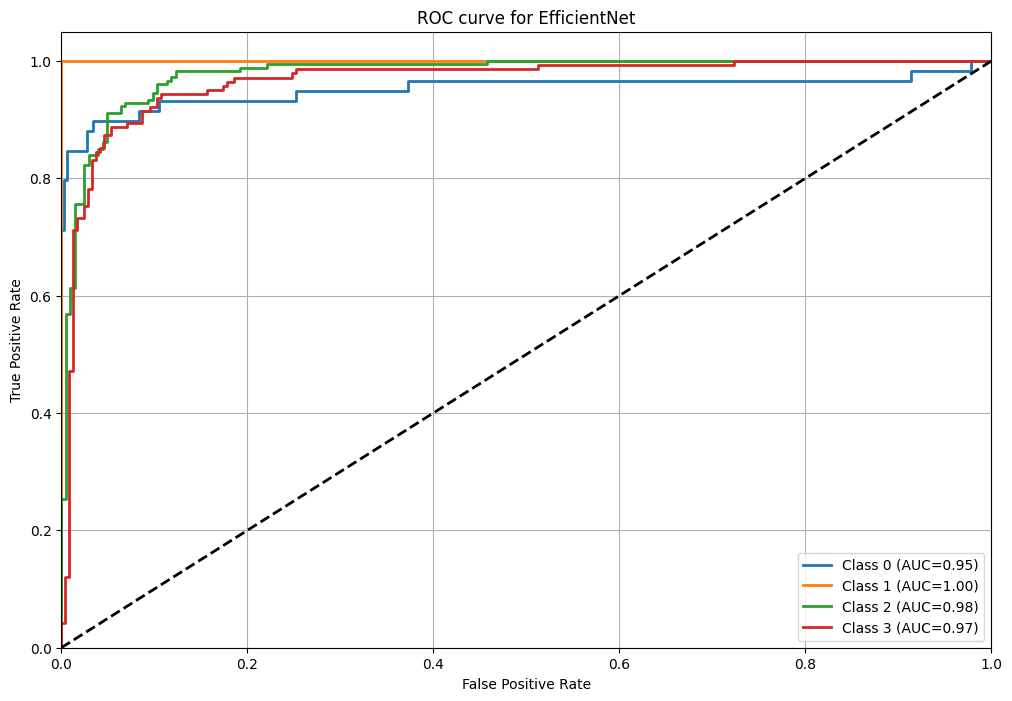

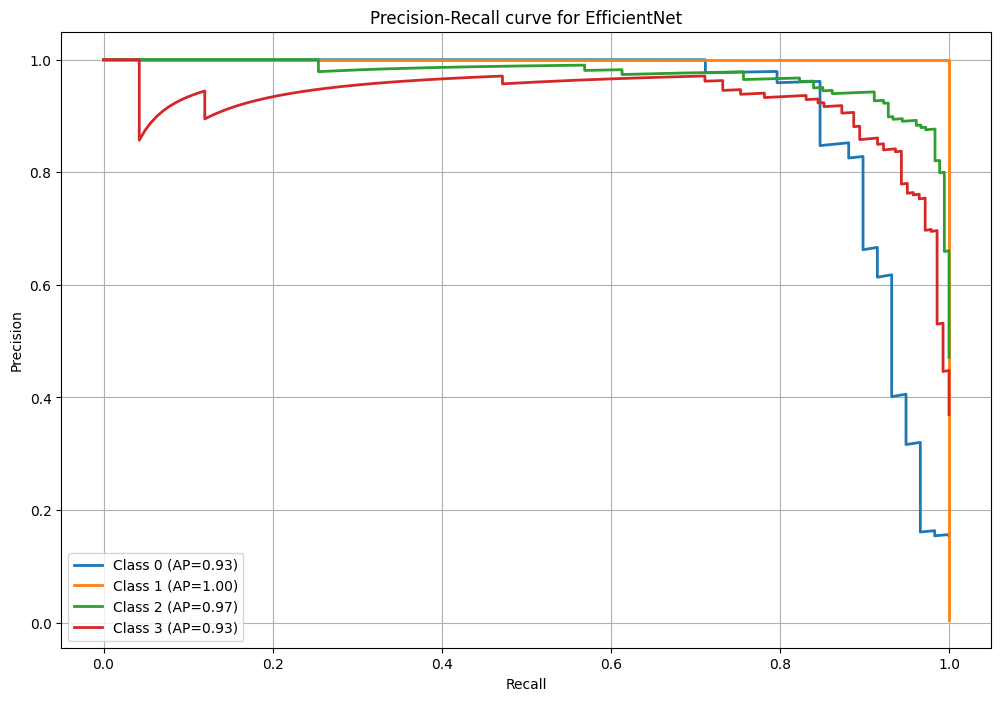

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


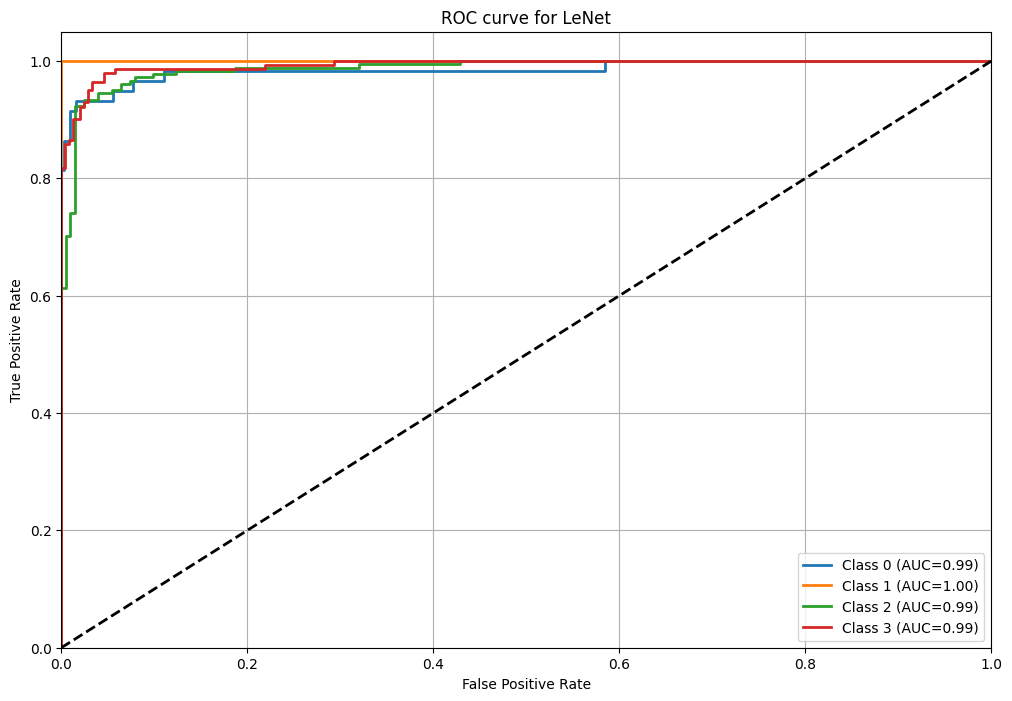

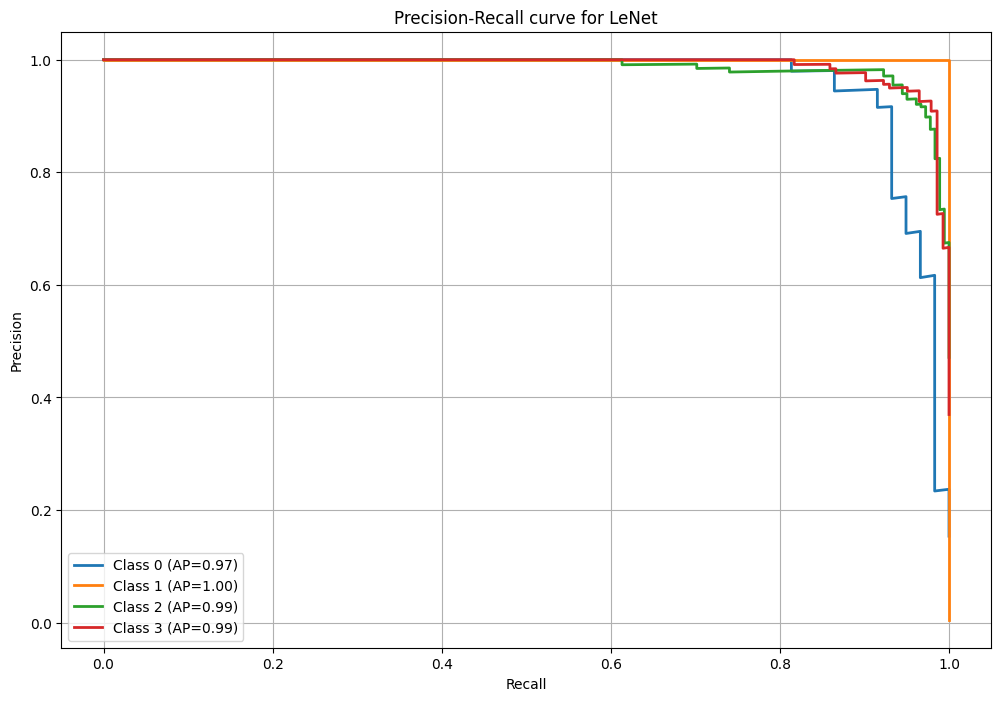

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


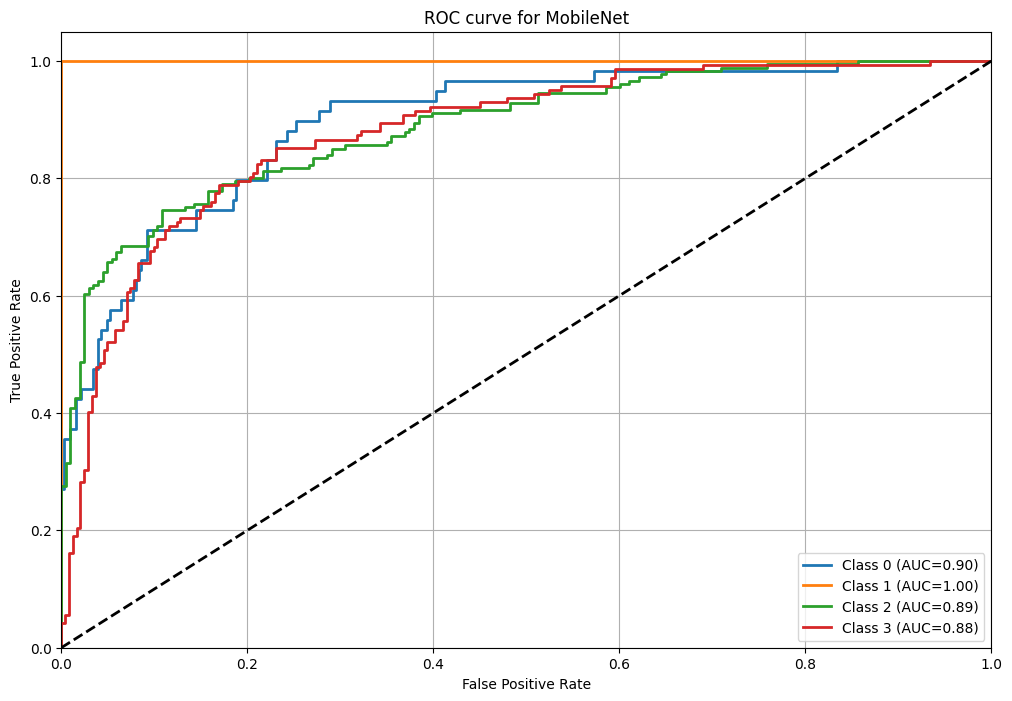

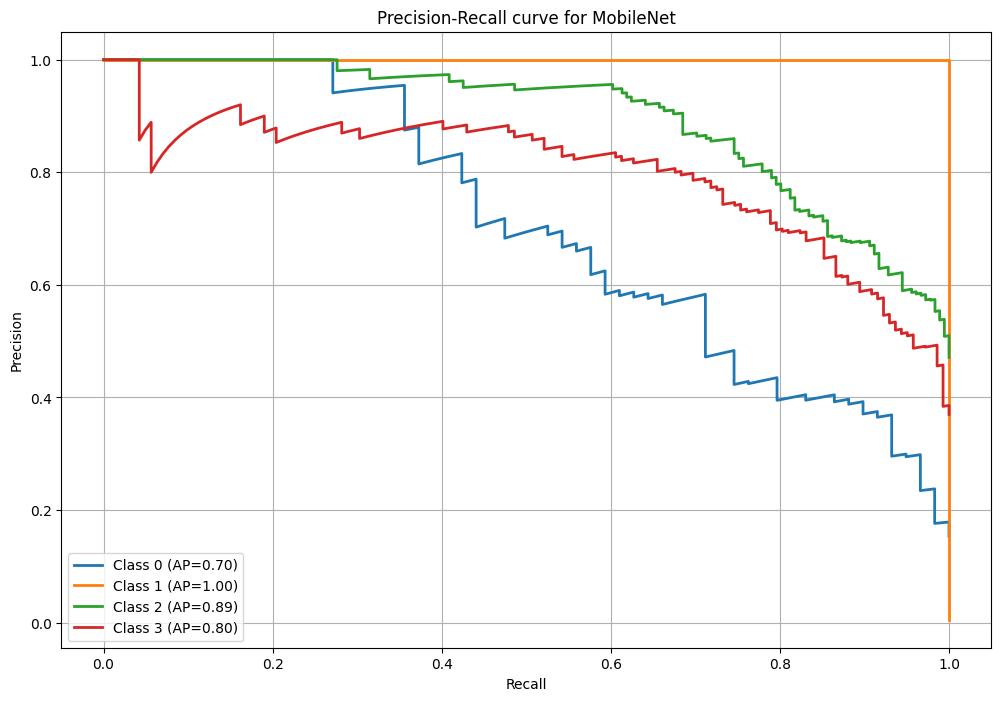

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


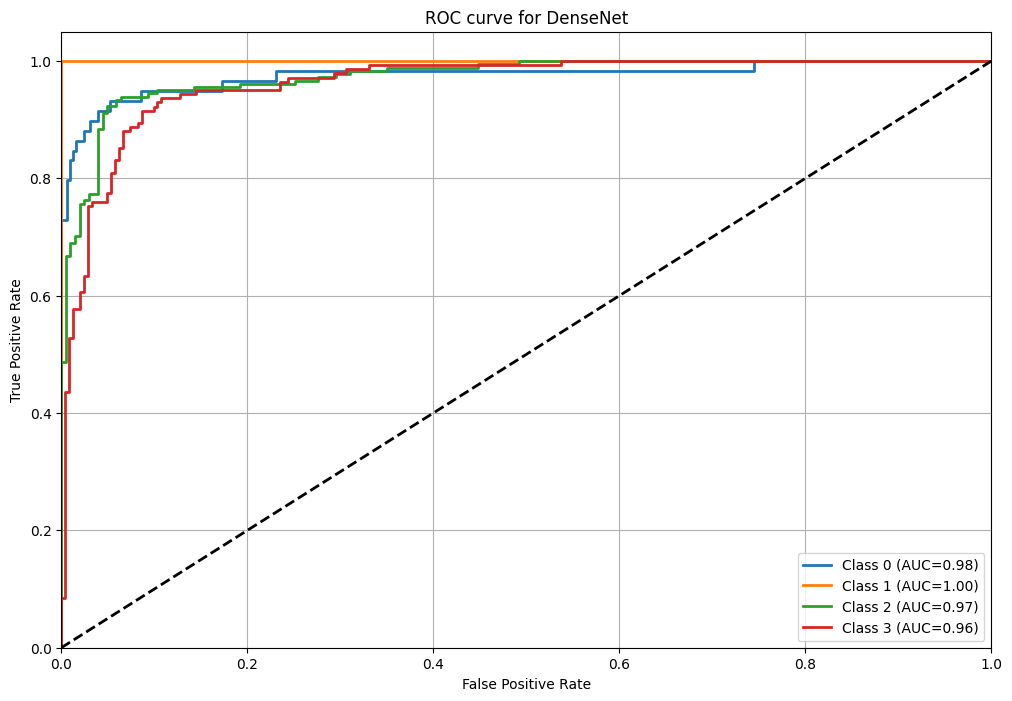

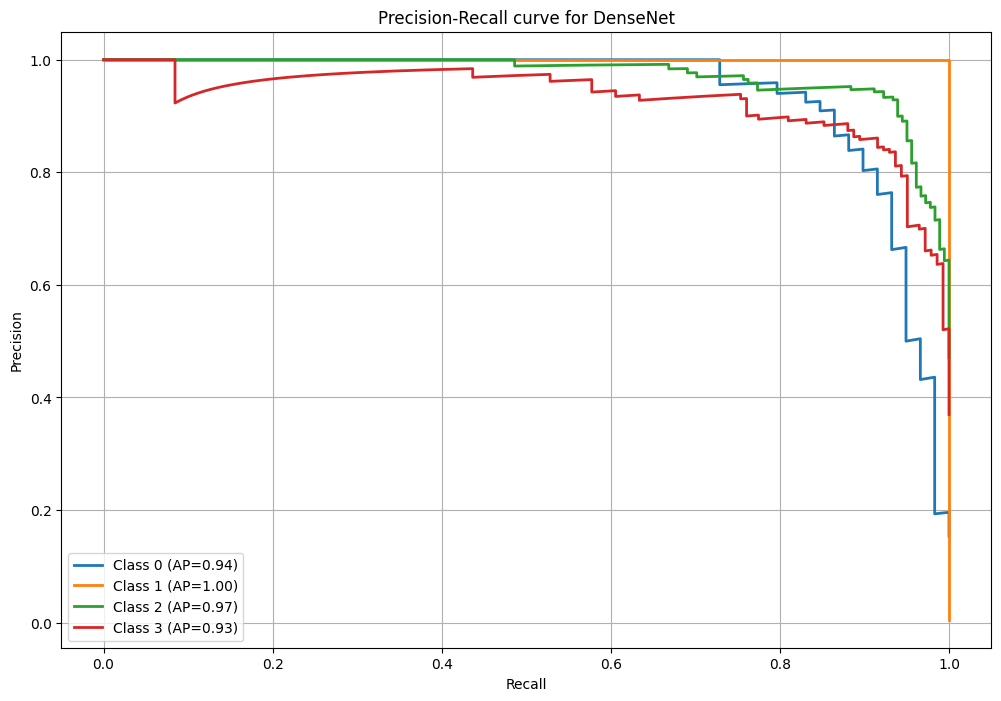

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd

# Helper function to plot ROC curve for each class
def plot_roc_curve(y_true, y_pred_probs, model_name, class_names):
    plt.figure(figsize=(12, 8))
    
    auc_values = []
    for i, class_name in enumerate(class_names):
        # Calculate ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_values.append(roc_auc)
        
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    return auc_values

# Helper function to plot Precision-Recall curve for each class
def plot_precision_recall_curve(y_true, y_pred_probs, model_name, class_names):
    plt.figure(figsize=(12, 8))
    
    ap_values = []
    for i, class_name in enumerate(class_names):
        # Calculate Precision-Recall curve and Average Precision for each class
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
        average_precision = average_precision_score(y_true[:, i], y_pred_probs[:, i])
        ap_values.append(average_precision)
        
        plt.plot(recall, precision, lw=2, label=f'{class_name} (AP={average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    return ap_values

# True labels for the test set (one-hot encoded)
y_true = y_test

# Class names for your 4 classes
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# List to store the results for each model
results = []

# Define a function to process a model (ROC + Precision-Recall + Append Results)
def process_model(model_name, y_pred_probs):
    roc_aucs = plot_roc_curve(y_true, y_pred_probs, model_name, class_names)
    ap_scores = plot_precision_recall_curve(y_true, y_pred_probs, model_name, class_names)
    
    # Append results to the table
    results.append([model_name, *roc_aucs, *ap_scores])

# -------------------- ResNet --------------------
y_pred_probs_resnet = model_resnet.predict(X_test)
process_model("ResNet", y_pred_probs_resnet)

# -------------------- U-Net --------------------
y_pred_probs_unet = model_unet.predict(X_test)
process_model("U-Net", y_pred_probs_unet)

# -------------------- EfficientNet --------------------
y_pred_probs_efficientnet = model_efficientnet.predict(X_test)
process_model("EfficientNet", y_pred_probs_efficientnet)

# -------------------- LeNet --------------------
y_pred_probs_lenet = model_lenet.predict(X_test)
process_model("LeNet", y_pred_probs_lenet)

# -------------------- MobileNet --------------------
y_pred_probs_mobilenet = model_mobilenet.predict(X_test)
process_model("MobileNet", y_pred_probs_mobilenet)

# -------------------- DenseNet --------------------
y_pred_probs_densenet = model_densenet.predict(X_test)
process_model("DenseNet", y_pred_probs_densenet)

# Display the results in a pandas DataFrame
columns = ['Model'] + [f'ROC AUC {class_name}' for class_name in class_names] + [f'PR AUC {class_name}' for class_name in class_names]
df_results = pd.DataFrame(results, columns=columns)





In [12]:
import pandas as pd

# Assuming df_results is your DataFrame containing the results
df_results = pd.DataFrame(results, columns=columns)

# Standard way to display a DataFrame in Jupyter or most Python environments
# print(df_results)

# If you are using Jupyter Notebook or JupyterLab, you can use this:
from IPython.display import display
display(df_results)


,Model,ROC AUC Class 0,ROC AUC Class 1,ROC AUC Class 2,ROC AUC Class 3,PR AUC Class 0,PR AUC Class 1,PR AUC Class 2,PR AUC Class 3
0,ResNet,0.995880,1.0,0.985684,0.984751,0.989374,1.0,0.985080,0.975521
1,U-Net,0.989674,1.0,0.987562,0.986410,0.985849,1.0,0.981886,0.982276
2,EfficientNet,0.952073,1.0,0.978527,0.965633,0.926011,1.0,0.973142,0.929744
3,LeNet,0.985085,1.0,0.987535,0.992987,0.966151,1.0,0.986838,0.989852
4,MobileNet,0.896115,1.0,0.887325,0.878710,0.704577,1.0,0.894044,0.801761
5,DenseNet,0.975385,1.0,0.973709,0.962810,0.942925,1.0,0.972834,0.932153


Ensembled ResNet, U-Net, LeNet and DenseNet based upon insights

# Results :

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, log_loss

# Assuming your y_test is one-hot encoded for multiclass, we convert it to label format
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_multiclass = np.argmax(y_test, axis=1)  # Convert y_test from one-hot to class labels
else:
    y_test_multiclass = y_test  # If y_test is already in label format

# Calculate predictions for each model
test_predictions_resnet = model_resnet.predict(X_test)
test_predictions_unet = model_unet.predict(X_test)
test_predictions_lenet = model_lenet.predict(X_test)
test_predictions_densenet = model_densenet.predict(X_test)

# Combine predictions into a matrix (each model's predictions stacked)
ensemble_predictions = np.array([
    test_predictions_resnet,
    test_predictions_unet,
    test_predictions_lenet,
    test_predictions_densenet
])

# Aggregate predictions by averaging across the models (soft voting)
ensemble_predictions_avg = np.mean(ensemble_predictions, axis=0)

# For multiclass, get the class with the highest probability
ensemble_predictions_multiclass = np.argmax(ensemble_predictions_avg, axis=1)

# Evaluate the ensemble model's accuracy and loss (ensure the test labels and predictions are in the same format)
ensemble_accuracy = accuracy_score(y_test_multiclass, ensemble_predictions_multiclass)
ensemble_loss = log_loss(y_test_multiclass, ensemble_predictions_avg)

# Output the results
print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Model Loss:", ensemble_loss)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Ensemble Model Accuracy: 0.9609375
Ensemble Model Loss: 0.1587048566617201


# Preprocessing on example image

In [21]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, input_shape):
    # Open the MRI image
    img = Image.open(image_path)
    # Resize the image to match the input shape of the model
    img = img.resize((input_shape[1], input_shape[0]))
    # Convert image to numpy array and normalize pixel values
    img_array = np.array(img) / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Get the shape of the preprocessed image
    img_shape = img_array.shape
    return img_array, img_shape

# Example usage:
image_path = '/kaggle/input/mri-alzheimer-dataset/Dataset/Non_Demented/non_1013.jpg'
input_shape = (150, 150, 3)

# Preprocess the MRI image and get its shape
preprocessed_image, image_shape = preprocess_image(image_path, input_shape)

# Print the shape of the preprocessed image
print("Preprocessed Image Shape:", image_shape)


Preprocessed Image Shape: (1, 150, 150)


In [23]:
import numpy as np

# Assuming preprocessed_image is your image array with shape (1, 150, 150)
preprocessed_image_with_rgb = np.expand_dims(preprocessed_image, axis=-1)  # Add the last dimension

# Repeat the last dimension to create 3 channels for RGB
preprocessed_image_with_rgb = np.repeat(preprocessed_image_with_rgb, 3, axis=-1)

# Now, the shape of preprocessed_image_with_rgb will be (1, 150, 150, 3)
print("Preprocessed Image Shape with RGB:", preprocessed_image_with_rgb.shape)


Preprocessed Image Shape with RGB: (1, 150, 150, 3)


## Prediction on example image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


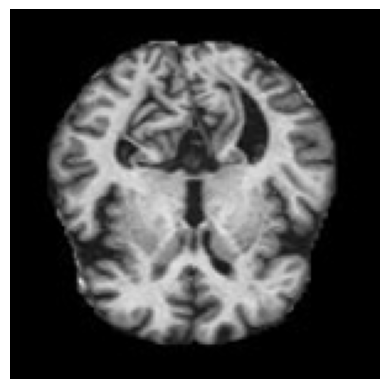

Predicted Class: Non_Demented


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Function to make predictions using the ensemble model
def predict_with_ensemble(models, preprocessed_image_with_rgb):
    # Make predictions with each model in the ensemble
    ensemble_predictions = []
    for model in models:
        predictions = model.predict(preprocessed_image_with_rgb)
        ensemble_predictions.append(predictions)
    
    # Combine predictions by averaging
    ensemble_predictions_avg = np.mean(ensemble_predictions, axis=0)
    
    # Get the predicted class with the highest probability
    predicted_class_idx = np.argmax(ensemble_predictions_avg)
    
    # Map predicted class indices to class names
    class_names = {
        0: "Mild_Demented",
        1: "Moderate_Demented",
        2: "Non_Demented",
        3: "Very_Mild_Demented"
    }
    
    # Get the predicted class name
    predicted_class_name = class_names.get(predicted_class_idx, "Unknown")
    
    return predicted_class_name

# Example usage:
input_shape = (150, 150, 3)  # Assuming input shape of the models in the ensemble is (150, 150, 3)
models = [model_unet, model_lenet, model_resnet, model_densenet]  # List of models in the ensemble

predicted_class_name = predict_with_ensemble(models, preprocessed_image_with_rgb)


# Now let's print the image
plt.imshow(preprocessed_image_with_rgb[0])
plt.axis('off')
plt.show()

print("Predicted Class:", predicted_class_name)


# Saving models, ensemble logic and preprocessing of image

In [26]:
import tensorflow as tf

# Save each model to a file
model_resnet.save('resnet_model.h5')
model_unet.save('unet_model.h5')
model_lenet.save('lenet_model.h5')
model_densenet.save('densenet_model.h5')

print("Models saved successfully!")


Models saved successfully!


In [27]:
import pickle

# Define the preprocessing function
def preprocess_image(image_path, target_size=(150, 150)):
    import cv2
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)    # Add batch dimension
    return image

# Save the preprocessing function to a file using pickle
with open('image_preprocessing.pkl', 'wb') as f:
    pickle.dump(preprocess_image, f)

print("Image preprocessing function saved successfully!")


Image preprocessing function saved successfully!


In [28]:
import pickle

# Define the ensemble prediction function
def ensemble_predict(models, image):
    predictions = [model.predict(image) for model in models]
    avg_prediction = np.mean(predictions, axis=0)
    predicted_class = np.argmax(avg_prediction, axis=1)
    return predicted_class, avg_prediction

# Save the ensemble logic using pickle
with open('ensemble_logic.pkl', 'wb') as f:
    pickle.dump(ensemble_predict, f)

print("Ensemble logic saved successfully!")


Ensemble logic saved successfully!
